In [1]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install nltk pandas scikit-learn


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 8.8 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.3/751.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:0000:01


[INFO] Dataset loaded
[INFO] Date Preprocessing and cleaning Done
[INFO] Graphs Created
[INFO] Graph Data Saved -> graphs.pt


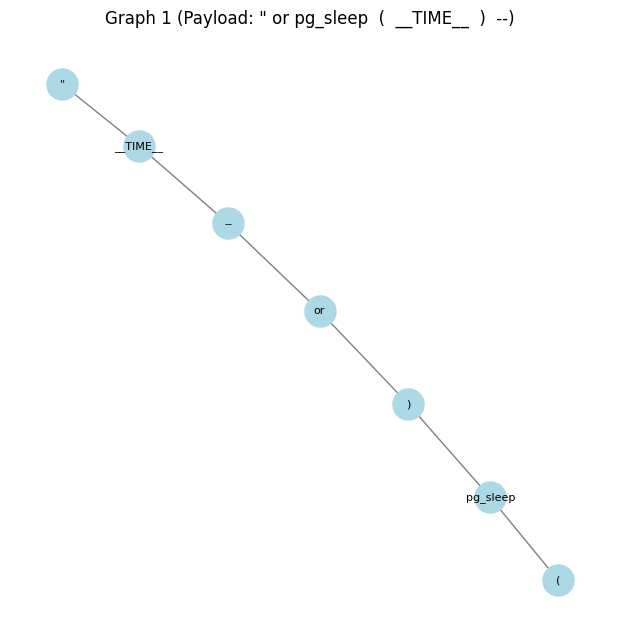

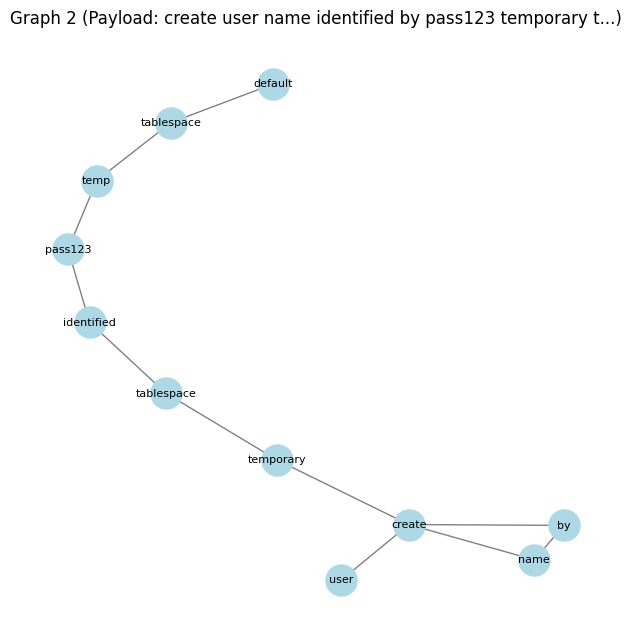

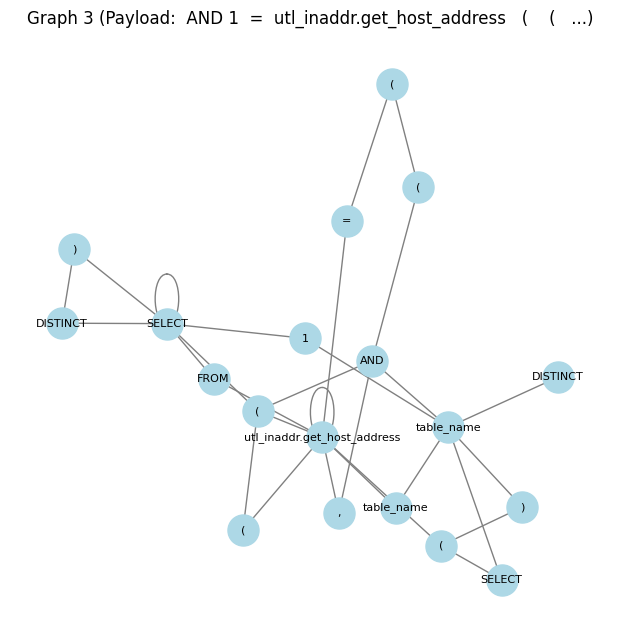

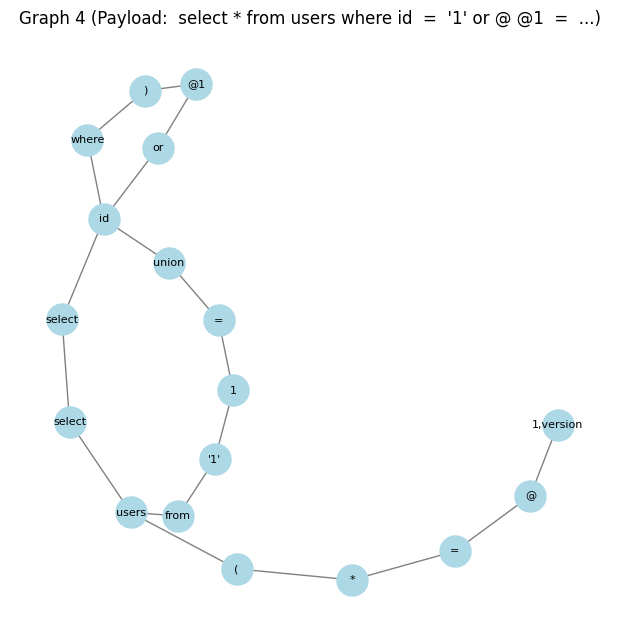

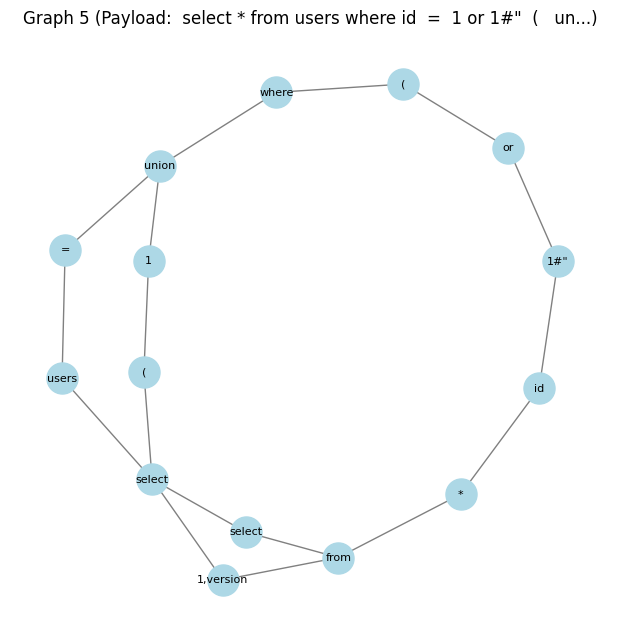

In [4]:
import torch
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#  Load dataset
df = pd.read_csv("/kaggle/input/sqli-xss-payload-dataset-for-waf/dataset.csv")
print("[INFO] Dataset loaded")

#  Remove NaN & invalid labels
df = df[df["Label"].astype(str).str.isnumeric()]  # Keep only numeric labels (0 or 1)
df["Label"] = df["Label"].astype(float)  # Convert to float

#  Ensure Payload column is properly formatted as strings
df["Payload"] = df["Payload"].astype(str).fillna("")
print("[INFO] Date Preprocessing and cleaning Done")

#  Graph Conversion Function
def text_to_graph(text):
    if not isinstance(text, str) or text.strip() == "":
        return [], {}, torch.empty((2, 0), dtype=torch.long)

    words = text.split()
    if len(words) == 0:
        return [], {}, torch.empty((2, 0), dtype=torch.long)

    # Assign a unique index to each unique word
    word_to_index = {word: idx for idx, word in enumerate(set(words))}
    
    # Create edges between adjacent words using their unique indices
    edges = [(word_to_index[words[i]], word_to_index[words[i + 1]]) for i in range(len(words) - 1)]
    edge_index = torch.tensor(edges, dtype=torch.long).t() if edges else torch.empty((2, 0), dtype=torch.long)

    return list(word_to_index.keys()), word_to_index, edge_index



graphs = []
payloads = []
word_mappings = []  # Store word-to-index mappings for labels

for _, row in df.iterrows():
    payload, label = row["Payload"], row["Label"]
    nodes, word_to_index, edge_index = text_to_graph(payload) 

    if len(nodes) == 0:
        continue

    x = torch.rand(len(nodes), 16) * 0.01
    y = torch.tensor([label], dtype=torch.float)

    graphs.append(Data(x=x, edge_index=edge_index, y=y))
    payloads.append(payload)
    word_mappings.append(word_to_index)  #  Store word-to-index mapping


print("[INFO] Graphs Created")
torch.save(graphs, "/kaggle/working/graphs.pt")
print("[INFO] Graph Data Saved -> graphs.pt")

# Visualize First 5 Graphs with Node Labels
def plot_graph(graph, payload, idx):
    G = nx.Graph()
    num_nodes = graph.x.shape[0]
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(graph.edge_index.t().tolist())

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G)  # Layout for better spacing

    # Ensure node_labels only includes nodes that exist in G
    words = payload.split()
    node_labels = {i: words[i] for i in range(min(len(words), num_nodes))}  # Match words to valid nodes

    # Ensure no missing keys in pos
    node_labels = {k: v for k, v in node_labels.items() if k in G.nodes}

    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=500, font_size=8)
    plt.title(f"Graph {idx+1} (Payload: {payload[:50]}...)" if len(payload) > 50 else f"Graph {idx+1} (Payload: {payload})")
    plt.show()


for i in range(min(5, len(graphs))):  
    plot_graph(graphs[i], payloads[i], i)


In [5]:
#  Train-Test Split
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

print(f"[INFO] Training samples: {len(train_graphs)}, Testing samples: {len(test_graphs)}")


[INFO] Training samples: 35589, Testing samples: 8898


In [6]:
# Save Data
torch.save(train_graphs, "/kaggle/working/train_graphs.pt")
torch.save(test_graphs, "/kaggle/working/test_graphs.pt")
print("[INFO] Train & Test Data Saved")

[INFO] Train & Test Data Saved


In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

class ModelGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, 1)  # For binary classification
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for module in [self.conv1, self.conv2, self.classifier]:
            if hasattr(module, 'weight') and module.weight is not None:
                torch.nn.init.xavier_uniform_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                torch.nn.init.constant_(module.bias, 0)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.leaky_relu(self.conv1(x, edge_index), negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.leaky_relu(self.conv2(x, edge_index), negative_slope=0.1)
        
        # Global mean pooling for graph-level classification
        x = global_mean_pool(x, batch)
        return self.classifier(x).squeeze(-1)

# Data preparation
train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=64)

# Model setup
model = ModelGCN(input_dim=graphs[0].x.shape[1]).to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# Training loop
best_val_acc = 0
for epoch in range(1, 30):
    # Training phase
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            batch = batch.to(device)
            optimizer.zero_grad()
            
            out = model(batch)
            loss = criterion(out, batch.y.float())
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # Validation phase
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y.float()).item()
            preds = (torch.sigmoid(out) > 0.5).float()
            val_correct += (preds == batch.y).sum().item()

    # Metrics calculation
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pth")

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

print("[INFO] Training completed")

[INFO] Using device: cpu


Epoch 1: 100%|██████████| 1113/1113 [00:12<00:00, 90.77batch/s, loss=0.675]


Epoch 01: Train Loss: 0.6816 | Val Loss: 0.6795 | Val Acc: 0.5796


Epoch 2: 100%|██████████| 1113/1113 [00:12<00:00, 91.57batch/s, loss=0.732]


Epoch 02: Train Loss: 0.6810 | Val Loss: 0.6789 | Val Acc: 0.5796


Epoch 3: 100%|██████████| 1113/1113 [00:12<00:00, 89.04batch/s, loss=0.671]


Epoch 03: Train Loss: 0.6803 | Val Loss: 0.6784 | Val Acc: 0.5796


Epoch 4: 100%|██████████| 1113/1113 [00:12<00:00, 91.98batch/s, loss=0.734]


Epoch 04: Train Loss: 0.6795 | Val Loss: 0.6767 | Val Acc: 0.5796


Epoch 5: 100%|██████████| 1113/1113 [00:12<00:00, 89.63batch/s, loss=0.673]


Epoch 05: Train Loss: 0.6778 | Val Loss: 0.6743 | Val Acc: 0.5796


Epoch 6: 100%|██████████| 1113/1113 [00:11<00:00, 92.97batch/s, loss=0.671]


Epoch 06: Train Loss: 0.6759 | Val Loss: 0.6713 | Val Acc: 0.5796


Epoch 7: 100%|██████████| 1113/1113 [00:12<00:00, 91.16batch/s, loss=0.648]


Epoch 07: Train Loss: 0.6745 | Val Loss: 0.6672 | Val Acc: 0.5796


Epoch 8: 100%|██████████| 1113/1113 [00:12<00:00, 89.34batch/s, loss=0.775]


Epoch 08: Train Loss: 0.6707 | Val Loss: 0.6618 | Val Acc: 0.5796


Epoch 9: 100%|██████████| 1113/1113 [00:12<00:00, 91.08batch/s, loss=0.599]


Epoch 09: Train Loss: 0.6652 | Val Loss: 0.6499 | Val Acc: 0.5943


Epoch 10: 100%|██████████| 1113/1113 [00:12<00:00, 90.61batch/s, loss=0.812]


Epoch 10: Train Loss: 0.6579 | Val Loss: 0.6436 | Val Acc: 0.6070


Epoch 11: 100%|██████████| 1113/1113 [00:11<00:00, 92.82batch/s, loss=0.702]


Epoch 11: Train Loss: 0.6485 | Val Loss: 0.6263 | Val Acc: 0.6370


Epoch 12: 100%|██████████| 1113/1113 [00:12<00:00, 90.77batch/s, loss=0.555]


Epoch 12: Train Loss: 0.6390 | Val Loss: 0.6194 | Val Acc: 0.6339


Epoch 13: 100%|██████████| 1113/1113 [00:12<00:00, 92.67batch/s, loss=0.712]


Epoch 13: Train Loss: 0.6304 | Val Loss: 0.6047 | Val Acc: 0.6488


Epoch 14: 100%|██████████| 1113/1113 [00:12<00:00, 91.67batch/s, loss=0.705]


Epoch 14: Train Loss: 0.6214 | Val Loss: 0.5972 | Val Acc: 0.6613


Epoch 15: 100%|██████████| 1113/1113 [00:12<00:00, 90.61batch/s, loss=0.688]


Epoch 15: Train Loss: 0.6139 | Val Loss: 0.5987 | Val Acc: 0.6459


Epoch 16: 100%|██████████| 1113/1113 [00:11<00:00, 93.91batch/s, loss=0.553]


Epoch 16: Train Loss: 0.6078 | Val Loss: 0.5738 | Val Acc: 0.7014


Epoch 17: 100%|██████████| 1113/1113 [00:11<00:00, 92.91batch/s, loss=0.4]  


Epoch 17: Train Loss: 0.6040 | Val Loss: 0.5727 | Val Acc: 0.6653


Epoch 18: 100%|██████████| 1113/1113 [00:12<00:00, 92.18batch/s, loss=0.442]


Epoch 18: Train Loss: 0.5986 | Val Loss: 0.5637 | Val Acc: 0.6717


Epoch 19: 100%|██████████| 1113/1113 [00:12<00:00, 91.81batch/s, loss=0.681]


Epoch 19: Train Loss: 0.5939 | Val Loss: 0.5530 | Val Acc: 0.7285


Epoch 20: 100%|██████████| 1113/1113 [00:12<00:00, 91.72batch/s, loss=0.673]


Epoch 20: Train Loss: 0.5913 | Val Loss: 0.5518 | Val Acc: 0.6867


Epoch 21: 100%|██████████| 1113/1113 [00:12<00:00, 92.29batch/s, loss=0.81] 


Epoch 21: Train Loss: 0.5882 | Val Loss: 0.5677 | Val Acc: 0.6680


Epoch 22: 100%|██████████| 1113/1113 [00:12<00:00, 91.99batch/s, loss=0.385]


Epoch 22: Train Loss: 0.5846 | Val Loss: 0.5584 | Val Acc: 0.6714


Epoch 23: 100%|██████████| 1113/1113 [00:12<00:00, 92.57batch/s, loss=0.945]


Epoch 23: Train Loss: 0.5859 | Val Loss: 0.5441 | Val Acc: 0.7185


Epoch 24: 100%|██████████| 1113/1113 [00:12<00:00, 92.16batch/s, loss=0.623]


Epoch 24: Train Loss: 0.5810 | Val Loss: 0.5452 | Val Acc: 0.7160


Epoch 25: 100%|██████████| 1113/1113 [00:12<00:00, 91.61batch/s, loss=0.694]


Epoch 25: Train Loss: 0.5787 | Val Loss: 0.5363 | Val Acc: 0.7194


Epoch 26: 100%|██████████| 1113/1113 [00:12<00:00, 92.67batch/s, loss=0.735]


Epoch 26: Train Loss: 0.5809 | Val Loss: 0.5402 | Val Acc: 0.7179


Epoch 27: 100%|██████████| 1113/1113 [00:12<00:00, 92.15batch/s, loss=0.537]


Epoch 27: Train Loss: 0.5781 | Val Loss: 0.5393 | Val Acc: 0.7193


Epoch 28: 100%|██████████| 1113/1113 [00:12<00:00, 92.59batch/s, loss=0.581]


Epoch 28: Train Loss: 0.5773 | Val Loss: 0.5441 | Val Acc: 0.6851


Epoch 29: 100%|██████████| 1113/1113 [00:11<00:00, 92.93batch/s, loss=0.651]


Epoch 29: Train Loss: 0.5780 | Val Loss: 0.5388 | Val Acc: 0.7192
[INFO] Training completed
